# Домашняя работа 4. Кластеризация.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [ODS: Обучение без учителя: PCA и кластеризация](https://habrahabr.ru/company/ods/blog/325654/)
- [Интересные алгоритмы кластеризации, часть первая: Affinity propagation](https://habrahabr.ru/post/321216/) и другие статьи цикла
- [Глава 7: кластеризация и визуализация. К. В. Воронцов](http://www.machinelearning.ru/wiki/images/6/6d/Voron-ML-1.pdf)
- [Документация sklearn.clustering](http://scikit-learn.org/stable/modules/clustering.html)
- [K-Means Clustering - The Math of Intelligence. Siraj Raval](https://www.youtube.com/watch?v=9991JlKnFmk) объяснение с программированием KMeans вручную

## Центры кластеров (6 баллов)

Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.

Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.

Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare. Полный датасет доступен здесь: https://archive.org/details/201309_foursquare_dataset_umn. Но в `../../data/checkins.csv.gz` я подготовил данные и оставил только 100000 элементов, иначе бы KMeans обучался пол дня.

Найдем на Google Maps координаты офисов компании:

```
33.751277, -118.188740 (Los Angeles)
25.867736, -80.324116 (Miami)
51.503016, -0.075479 (London)
52.378894, 4.885084 (Amsterdam)
39.366487, 117.036146 (Beijing)
-33.868457, 151.205134 (Sydney)
```

###  2.0 Read data (0.5 балла): 
**Загрузите датасет используя pandas `checkins.csv.gz`. Выведите его размер, первые 5 строк таблицы, статистическиую сводку(describe) **

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
df = pd.read_csv("data/checkins.csv.gz", na_values='?') 
df.head()

,latitude,longitude
0,38.895112,-77.036366
1,33.800745,-84.410520
2,45.523452,-122.676207
3,40.764462,-111.904565
4,33.448377,-112.074037


In [2]:
df.shape

(100000, 2)

In [3]:
df.describe()

,latitude,longitude
count,100000.000000,100000.000000
mean,36.886388,-89.396849
std,8.351517,35.579317
min,-45.031162,-159.670833
25%,33.494170,-112.074037
50%,38.646991,-87.743938
75%,40.740389,-75.163789
max,67.631479,174.908056


###  2.1 MeanShift (1 балл): 
Для данной задачи мы не знаем сколько кластеров вообще существует, и есть ли они, поэтому воспользуемся методом, который сам находит нужное количество кластеров. Используйте `MeanShift`, указав `bandwidth=0.1`, что в переводе из градусов в метры колеблется примерно от 5 до 10 км в средних широтах. Документацию по нему вы можете найти в документации SKlearn [тут](http://scikit-learn.org/stable/modules/clustering.html#mean-shift).

**Обучите кластеризатор на всех данных.** Выполнение в 4 потока на i5 заняло 2 минуты.

In [4]:
from sklearn.cluster import MeanShift
ms =  MeanShift(bandwidth=0.1)
%time ms.fit(df.head(1000))

CPU times: user 831 ms, sys: 185 µs, total: 831 ms
Wall time: 830 ms


MeanShift(bandwidth=0.1, bin_seeding=False, cluster_all=True, min_bin_freq=1,
     n_jobs=None, seeds=None)

In [5]:
ms = MeanShift()
%time ms.fit(df.head(10000))

CPU times: user 33.5 s, sys: 231 ms, total: 33.7 s
Wall time: 33.8 s


MeanShift(bandwidth=None, bin_seeding=False, cluster_all=True, min_bin_freq=1,
     n_jobs=None, seeds=None)

### 2.2 Visualization (0.5 балла): 
**Визуализируйте с помощью matplotlib все точки из датасета** так, чтобы они были разукрашены в соответсвии с кластером к которому они принадлежат. **Добавьте на ваш график ещё точки расположений офисов**, сделайте их большими и красными, чтобы было видно. Рисовать каким-то образом карту мира под точками НЕ надо.

23


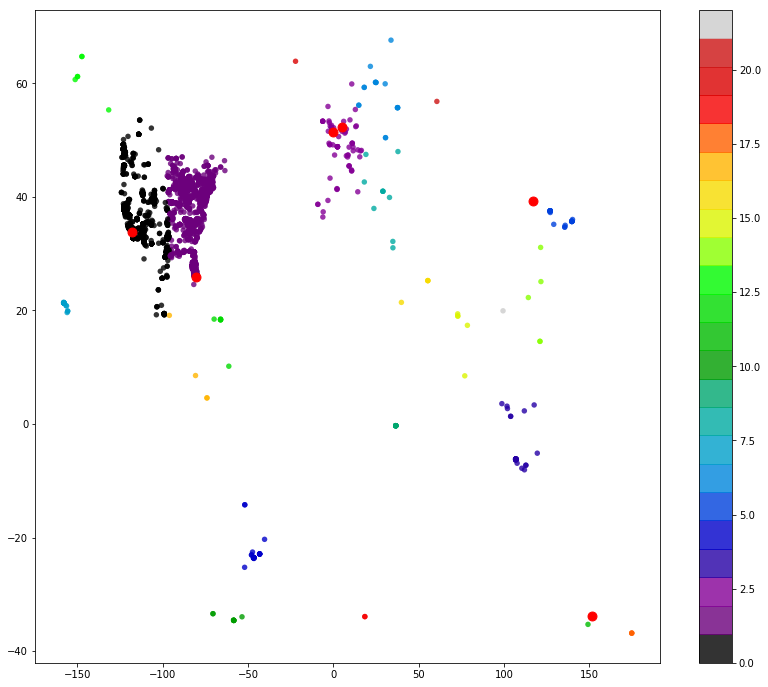

In [22]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14,12))
plt.scatter(df.head(10000)['longitude'], df.head(10000)['latitude'], c=ms.labels_, cmap=plt.cm.get_cmap('nipy_spectral', 23),
            edgecolor='none', alpha=0.8, s=30,)
plt.colorbar()
y = np.array([33.751277, 25.867736, 51.503016, 52.378894,  39.366487, -33.868457])
x = np.array([-118.188740, -80.324116, -0.075479, 4.885084, 117.036146, 151.205134])             
plt.scatter(x,y, c="red", s=80)
print(len(set(ms.labels_)))

###  2.3 Filter clusters (2 балла): 
Как видим на графике, некоторые из получившихся кластеров содержат слишком мало точек — такие кластеры не интересны рекламодателям. Поэтому надо определить, какие из кластеров содержат, скажем, больше 15 элементов. Центры этих кластеров и являются оптимальными для размещения. 

**Выведите количество кластеров, которое удовлетворяет этому условию.**

**Hint**: `itertools.groupby`

In [30]:
dff = df.head(10000)
dff['label'] = ms.labels_
n_dotes_in_cluster = dff.groupby('label')['longitude'].count()
len(n_dotes_in_cluster[n_dotes_in_cluster > 15])

/home/galia/.pyenv/versions/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


8

###  Задание 2.4 (2 балла): 
Как мы помним, необходимо разместить только 20 баннеров близ офисов компании. Осталось определить 20 ближайших к ним центров кластеров. Т.е. посчитать дистанцию до ближайшего офиса для каждой точки и выбрать 20 с наименьшим значением.

**Выведите эти 20 центров кластеров, отсортрованных по возрастанию расстояния до ближайшего офиса.**

**Hint:** Для вычисления расстояния вы можете использовать обычную евклидову метрику и предполагать, что земля плоская. А можете использовать `geopy.distance.vincenty` если поймёте как.

In [54]:
#!pip3 install geopy
from scipy.spatial import cKDTree
from geopy.distance import vincenty
#vincenty((df['latitude'],df['longitude'])).meters
y = np.array([33.751277, 25.867736, 51.503016, 52.378894,  39.366487, -33.868457])
x = np.array([-118.188740, -80.324116, -0.075479, 4.885084, 117.036146, 151.205134])
def closest_pts(A, B_lat, B_lng):
    a_x = B_lat
    a_y = B_lng
    b_x = A.ravel()[0::2]
    b_y = A.ravel()[1::2]

    a = np.c_[a_x, a_y]
    b = np.c_[b_x, b_y]
    indx = cKDTree(b).query(a,k=1)[1]
    return b_x[indx], b_y[indx]

centers = ms.cluster_centers_
c_x,c_y = closest_pts(centers, y, x)
closest = pd.DataFrame({'latitude':c_x, 'longitude':c_y })
closest

,latitude,longitude
0,34.793659,-114.342426
1,39.092877,-78.922211
2,50.246246,3.715277
3,50.246246,3.715277
4,36.086952,132.926740
5,-34.020910,150.970815


Координата центра кластера ближайшего к какому-то из офисов компании должны быть `(52.37296399032261, 4.8923172225806466)`. Если у вас не так, то считайте, что вы сделали что-то неправильно. 